In [1]:
from collections import defaultdict

from tqdm import tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.nn as nn


from torch import Tensor
from torchinfo import summary
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall
)
from torchmetrics.functional import (
    accuracy, precision, recall
)
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Makes the device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [6]:
# Locking the randomness seed
SEED = 42
def set_seed(seed: int = SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [7]:
N_SAMPLES = 15_000
N_FEATURES = 2

X, y = make_classification(
    n_samples=N_SAMPLES, 
    n_features=N_FEATURES,
    n_informative=2,
    n_redundant=0,
    random_state=SEED
)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    stratify=y,
    test_size=0.2,
    random_state=SEED
)

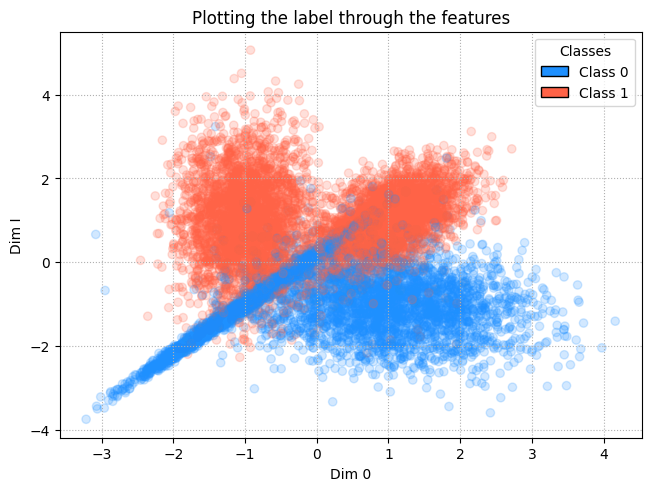

In [9]:
# visualization
colors_class = ['#1E90FF', '#FF6347']  # 0: blue, 1: red
cmap_classifier = ListedColormap(colors_class)

legend_elements = [
    Patch(facecolor=colors_class[0], edgecolor='k', label='Class 0'),
    Patch(facecolor=colors_class[1], edgecolor='k', label='Class 1'),
]

fig, ax = plt.subplots(layout='constrained')
ax.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap=cmap_classifier,
    # edgecolor='#696969',
    alpha=0.2
)
ax.set_title('Plotting the label through the features')
ax.set_xlabel('Dim 0')
ax.set_ylabel('Dim I')
ax.grid(True, linestyle=':')
ax.legend(handles=legend_elements, title="Classes")
plt.show()

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [11]:
# Splitting the validation set, (I know I could do it using the train test split)
N_SAMPLES_EVAL = 2000
X_train, X_eval = X_train[:-N_SAMPLES_EVAL, :], X_train[-N_SAMPLES_EVAL:, :]
y_train, y_eval = y_train[:-N_SAMPLES_EVAL], y_train[-N_SAMPLES_EVAL:]

In [12]:
# TensorDataset
train_dataset = TensorDataset(X_train, y_train)
eval_dataset = TensorDataset(X_eval, y_eval)
test_dataset = TensorDataset(X_test, y_test)

In [13]:
# DataLoader
N = 32  # batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=N,
    shuffle=True,
    generator=torch.Generator(device=device)
)
eval_loader = DataLoader(eval_dataset, generator=torch.Generator(device=device))
test_loader = DataLoader(test_dataset, generator=torch.Generator(device=device))

In [14]:
# model
class Net(nn.Module):
    def __init__(self, dropout: float = 0.2):
        super().__init__()
        self.input_block = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.hidden_block = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        self.output_layer = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x: Tensor):
        x = self.input_block(x)
        x = self.hidden_block(x)
        x = self.output_layer(x)
        return x

In [15]:
model = Net()

In [16]:
# Not yet available on windows
# model = torch.compile(model)

In [17]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       12
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       40
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       144
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       544
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      264
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      18
│    └─ReLU: 2-13                        --
│    └─Dropout: 2-14                     --
├─Sequential: 1-3                        --
│    └─Linear: 2-15                      3
│    └─Sigmoid: 2-16                     --
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0

In [18]:
# training configuration
EPOCHS = 10
LR = 1e-03
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.BCELoss()

In [19]:
# metrics
metrics = defaultdict(list)
metrics_collection_train = MetricCollection(
    {
        'accuracy_train': BinaryAccuracy(threshold=0.5),
        'precision_train': BinaryPrecision(threshold=0.5),
        'recall_train': BinaryRecall(threshold=0.5)
    }
)

metrics_collection_eval = MetricCollection(
    {
        'accuracy_eval': BinaryAccuracy(threshold=0.5),
        'precision_eval': BinaryPrecision(threshold=0.5),
        'recall_eval': BinaryRecall(threshold=0.5)
    }
)

In [20]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    metrics_collection_train.reset()
    batch_iterator = tqdm(train_loader, desc=f'Epoch: {epoch + 1}/{EPOCHS}')
    for X, y in batch_iterator:
        y_hat = model(X)
        loss = criterion(y_hat, y)
        metrics_collection_train.update(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        acc = accuracy(y_hat, y, task='binary', threshold=0.5).item()
        prec = precision(y_hat, y, task='binary', threshold=0.5).item()
        rec = recall(y_hat, y, task='binary', threshold=0.5).item()

        batch_iterator.set_postfix(
            {
                'loss': f'{total_loss / (batch_iterator.n + 1):.4f}',
                'acc': f'{acc:.4f}',
                'precision': f'{prec:.4f}',
                'recall': f'{rec:.4f}'
            }
        )
    loss_epoch = total_loss / len(train_loader)
    metrics['loss'].append(loss_epoch)
    computed_metrics_train = metrics_collection_train.compute()
    print(f'TRAIN: {computed_metrics_train}')
    for metric_name, metric_value in computed_metrics_train.items():
        metrics[metric_name].append(metric_value.item())

    if epoch % 2 == 0:
        metrics_collection_eval.reset()
        model.eval()
        y_hat_eval = model(X_eval)
        loss_eval = criterion(y_hat_eval, y_eval)
        metrics['loss_eval'].append(loss_eval)
        metrics_collection_eval.update(y_hat_eval, y_eval)
        computed_metrics_eval = metrics_collection_eval.compute()
        print(f'EVAL: {computed_metrics_eval} | LOSS EVAL: {loss_eval}')
        for metric_name, metric_value in computed_metrics_eval.items():
            metrics[metric_name].append(metric_value.item())

model.eval()
y_hat_test = model(X_test)
loss_test = criterion(y_hat_test, y_test)
acc_test = accuracy(y_hat_test, y_test, task='binary', threshold=0.5)
prec_test = precision(y_hat_test, y_test, task='binary', threshold=0.5)
rec_test = recall(y_hat_test, y_test, task='binary', threshold=0.5)
print(f'TEST: ACCURACY: {acc_test} | PRECISION: {prec_test} | RECALL: {rec_test}')

Epoch: 1/10: 100%|█████████| 313/313 [00:14<00:00, 21.80it/s, loss=0.6751, acc=0.7500, precision=0.7500, recall=0.7500]


TRAIN: {'accuracy_train': tensor(0.5744, device='cuda:0'), 'precision_train': tensor(0.8641, device='cuda:0'), 'recall_train': tensor(0.1768, device='cuda:0')}
EVAL: {'accuracy_eval': tensor(0.8795, device='cuda:0'), 'precision_eval': tensor(0.8421, device='cuda:0'), 'recall_eval': tensor(0.9377, device='cuda:0')} | LOSS EVAL: 0.562340259552002


Epoch: 2/10: 100%|█████████| 313/313 [00:12<00:00, 25.91it/s, loss=0.4844, acc=0.8125, precision=1.0000, recall=0.5714]


TRAIN: {'accuracy_train': tensor(0.8136, device='cuda:0'), 'precision_train': tensor(0.8930, device='cuda:0'), 'recall_train': tensor(0.7127, device='cuda:0')}


Epoch: 3/10: 100%|█████████| 313/313 [00:12<00:00, 26.02it/s, loss=0.4588, acc=0.8125, precision=0.8000, recall=0.6667]


TRAIN: {'accuracy_train': tensor(0.8145, device='cuda:0'), 'precision_train': tensor(0.9116, device='cuda:0'), 'recall_train': tensor(0.6967, device='cuda:0')}
EVAL: {'accuracy_eval': tensor(0.8940, device='cuda:0'), 'precision_eval': tensor(0.9057, device='cuda:0'), 'recall_eval': tensor(0.8824, device='cuda:0')} | LOSS EVAL: 0.38106343150138855


Epoch: 4/10: 100%|█████████| 313/313 [00:12<00:00, 25.18it/s, loss=0.4400, acc=0.8125, precision=1.0000, recall=0.6250]


TRAIN: {'accuracy_train': tensor(0.8173, device='cuda:0'), 'precision_train': tensor(0.9179, device='cuda:0'), 'recall_train': tensor(0.6971, device='cuda:0')}


Epoch: 5/10: 100%|█████████| 313/313 [00:14<00:00, 20.92it/s, loss=0.4369, acc=0.8125, precision=1.0000, recall=0.5714]


TRAIN: {'accuracy_train': tensor(0.8164, device='cuda:0'), 'precision_train': tensor(0.9111, device='cuda:0'), 'recall_train': tensor(0.7013, device='cuda:0')}
EVAL: {'accuracy_eval': tensor(0.8955, device='cuda:0'), 'precision_eval': tensor(0.9019, device='cuda:0'), 'recall_eval': tensor(0.8903, device='cuda:0')} | LOSS EVAL: 0.3520756959915161


Epoch: 6/10: 100%|█████████| 313/313 [00:14<00:00, 21.07it/s, loss=0.4313, acc=0.8125, precision=1.0000, recall=0.4000]


TRAIN: {'accuracy_train': tensor(0.8198, device='cuda:0'), 'precision_train': tensor(0.9092, device='cuda:0'), 'recall_train': tensor(0.7107, device='cuda:0')}


Epoch: 7/10: 100%|█████████| 313/313 [00:12<00:00, 24.57it/s, loss=0.4325, acc=0.8750, precision=0.8750, recall=0.8750]


TRAIN: {'accuracy_train': tensor(0.8154, device='cuda:0'), 'precision_train': tensor(0.9101, device='cuda:0'), 'recall_train': tensor(0.7001, device='cuda:0')}
EVAL: {'accuracy_eval': tensor(0.8950, device='cuda:0'), 'precision_eval': tensor(0.8931, device='cuda:0'), 'recall_eval': tensor(0.9002, device='cuda:0')} | LOSS EVAL: 0.3404107689857483


Epoch: 8/10: 100%|█████████| 313/313 [00:11<00:00, 27.19it/s, loss=0.4411, acc=0.8750, precision=1.0000, recall=0.7778]


TRAIN: {'accuracy_train': tensor(0.8130, device='cuda:0'), 'precision_train': tensor(0.9082, device='cuda:0'), 'recall_train': tensor(0.6965, device='cuda:0')}


Epoch: 9/10: 100%|█████████| 313/313 [00:07<00:00, 42.60it/s, loss=0.4402, acc=0.8750, precision=1.0000, recall=0.8000]


TRAIN: {'accuracy_train': tensor(0.8120, device='cuda:0'), 'precision_train': tensor(0.9044, device='cuda:0'), 'recall_train': tensor(0.6979, device='cuda:0')}
EVAL: {'accuracy_eval': tensor(0.8955, device='cuda:0'), 'precision_eval': tensor(0.8879, device='cuda:0'), 'recall_eval': tensor(0.9081, device='cuda:0')} | LOSS EVAL: 0.33189040422439575


Epoch: 10/10: 100%|████████| 313/313 [00:06<00:00, 44.97it/s, loss=0.4313, acc=0.8750, precision=1.0000, recall=0.7500]

TRAIN: {'accuracy_train': tensor(0.8166, device='cuda:0'), 'precision_train': tensor(0.9016, device='cuda:0'), 'recall_train': tensor(0.7109, device='cuda:0')}
TEST: ACCURACY: 0.8896666765213013 | PRECISION: 0.874201774597168 | RECALL: 0.9108449816703796


In [22]:
def evaluate_model(model, X, y, criterion, metrics_collection):
    model.eval()
    with torch.inference_mode():
        y_hat = model(X)
        loss = criterion(y_hat, y)
        metrics_collection.reset()
        metrics_collection.update(y_hat, y)
        computed = metrics_collection.compute()
    return loss.item(), {k: v.item() for k, v in computed.items()}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    metrics_collection_train.reset()

    batch_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for X, y in batch_iterator:
        y_hat = model(X)
        loss = criterion(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        metrics_collection_train.update(y_hat, y)

        # Pegando métricas rapidamente para mostrar no tqdm
        acc = accuracy(y_hat, y, task='binary', threshold=0.5).item()
        prec = precision(y_hat, y, task='binary', threshold=0.5).item()
        rec = recall(y_hat, y, task='binary', threshold=0.5).item()
        batch_iterator.set_postfix(loss=loss.item(), acc=f'{acc:.4f}', precision=f'{prec:.4f}', recall=f'{rec:.4f}')

    # Métricas de treino da época
    avg_loss = total_loss / len(train_loader)
    metrics['loss'].append(avg_loss)
    train_metrics = metrics_collection_train.compute()
    print(f'TRAIN: {train_metrics}')
    for name, value in train_metrics.items():
        metrics[name].append(value.item())

    # Avaliação a cada 2 épocas
    if epoch % 2 == 0:
        loss_eval, eval_metrics = evaluate_model(model, X_eval, y_eval, criterion, metrics_collection_eval)
        print(f'EVAL: {eval_metrics} | LOSS EVAL: {loss_eval:.4f}')
        metrics['loss_eval'].append(loss_eval)
        for name, value in eval_metrics.items():
            metrics[name].append(value)

# Teste final
loss_test, test_metrics = evaluate_model(model, X_test, y_test, criterion, metrics_collection_eval)
print(f'TEST: {test_metrics} | LOSS TEST: {loss_test:.4f}')

Epoch 1/10: 100%|███████████| 313/313 [00:12<00:00, 25.53it/s, acc=0.8750, loss=0.363, precision=1.0000, recall=0.7143]


TRAIN: {'accuracy_train': tensor(0.8215, device='cuda:0'), 'precision_train': tensor(0.9075, device='cuda:0'), 'recall_train': tensor(0.7161, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8960000276565552, 'precision_eval': 0.8902912735939026, 'recall_eval': 0.9061264991760254} | LOSS EVAL: 0.3224


Epoch 2/10: 100%|███████████| 313/313 [00:12<00:00, 24.39it/s, acc=0.8750, loss=0.352, precision=1.0000, recall=0.7500]


TRAIN: {'accuracy_train': tensor(0.8190, device='cuda:0'), 'precision_train': tensor(0.9096, device='cuda:0'), 'recall_train': tensor(0.7085, device='cuda:0')}


Epoch 3/10: 100%|████████████| 313/313 [00:13<00:00, 22.94it/s, acc=0.8125, loss=0.46, precision=0.9000, recall=0.8182]


TRAIN: {'accuracy_train': tensor(0.8169, device='cuda:0'), 'precision_train': tensor(0.9077, device='cuda:0'), 'recall_train': tensor(0.7057, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8939999938011169, 'precision_eval': 0.8717471957206726, 'recall_eval': 0.926877498626709} | LOSS EVAL: 0.3251


Epoch 4/10: 100%|███████████| 313/313 [00:11<00:00, 26.27it/s, acc=0.8750, loss=0.343, precision=1.0000, recall=0.8182]


TRAIN: {'accuracy_train': tensor(0.8186, device='cuda:0'), 'precision_train': tensor(0.9045, device='cuda:0'), 'recall_train': tensor(0.7125, device='cuda:0')}


Epoch 5/10: 100%|███████████| 313/313 [00:12<00:00, 26.02it/s, acc=0.7500, loss=0.489, precision=1.0000, recall=0.5556]


TRAIN: {'accuracy_train': tensor(0.8172, device='cuda:0'), 'precision_train': tensor(0.9118, device='cuda:0'), 'recall_train': tensor(0.7025, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8914999961853027, 'precision_eval': 0.869767427444458, 'recall_eval': 0.9239130616188049} | LOSS EVAL: 0.3244


Epoch 6/10: 100%|███████████| 313/313 [00:13<00:00, 22.56it/s, acc=0.8125, loss=0.393, precision=1.0000, recall=0.5714]


TRAIN: {'accuracy_train': tensor(0.8195, device='cuda:0'), 'precision_train': tensor(0.9046, device='cuda:0'), 'recall_train': tensor(0.7145, device='cuda:0')}


Epoch 7/10: 100%|███████████| 313/313 [00:12<00:00, 25.04it/s, acc=0.8125, loss=0.497, precision=0.3333, recall=0.5000]


TRAIN: {'accuracy_train': tensor(0.8165, device='cuda:0'), 'precision_train': tensor(0.9040, device='cuda:0'), 'recall_train': tensor(0.7083, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8985000252723694, 'precision_eval': 0.895405650138855, 'recall_eval': 0.9051383137702942} | LOSS EVAL: 0.3249


Epoch 8/10: 100%|███████████| 313/313 [00:09<00:00, 34.03it/s, acc=0.6875, loss=0.584, precision=1.0000, recall=0.5833]


TRAIN: {'accuracy_train': tensor(0.8179, device='cuda:0'), 'precision_train': tensor(0.9090, device='cuda:0'), 'recall_train': tensor(0.7067, device='cuda:0')}


Epoch 9/10: 100%|███████████| 313/313 [00:07<00:00, 43.10it/s, acc=0.6875, loss=0.608, precision=0.8000, recall=0.5000]


TRAIN: {'accuracy_train': tensor(0.8186, device='cuda:0'), 'precision_train': tensor(0.9070, device='cuda:0'), 'recall_train': tensor(0.7101, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8955000042915344, 'precision_eval': 0.8879227042198181, 'recall_eval': 0.9081027507781982} | LOSS EVAL: 0.3219


Epoch 10/10: 100%|██████████| 313/313 [00:07<00:00, 42.41it/s, acc=0.7500, loss=0.518, precision=0.7778, recall=0.7778]


TRAIN: {'accuracy_train': tensor(0.8213, device='cuda:0'), 'precision_train': tensor(0.9095, device='cuda:0'), 'recall_train': tensor(0.7137, device='cuda:0')}
TEST: {'accuracy_eval': 0.8933333158493042, 'precision_eval': 0.8838416337966919, 'recall_eval': 0.9061876535415649} | LOSS TEST: 0.3220


In [23]:
def train_one_epoch(
    model,
    train_loader,
    optimizer,
    criterion,
    metrics_collection,
    metrics_dict,
    epoch,
    total_epochs
):
    model.train()
    total_loss = 0.0
    metrics_collection.reset()
    batch_iterator = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{total_epochs}')

    for X, y in batch_iterator:
        y_hat = model(X)
        loss = criterion(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        metrics_collection.update(y_hat, y)

        # Métricas rápidas para exibir no tqdm
        acc = accuracy(y_hat, y, task='binary', threshold=0.5).item()
        prec = precision(y_hat, y, task='binary', threshold=0.5).item()
        rec = recall(y_hat, y, task='binary', threshold=0.5).item()
        batch_iterator.set_postfix(
            loss=f'{loss.item():.4f}',
            acc=f'{acc:.4f}',
            precision=f'{prec:.4f}',
            recall=f'{rec:.4f}'
        )

    # Após a época
    loss_epoch = total_loss / len(train_loader)
    metrics_dict['loss'].append(loss_epoch)
    computed_metrics = metrics_collection.compute()
    print(f'TRAIN: {computed_metrics}')
    for name, value in computed_metrics.items():
        metrics_dict[name].append(value.item())

In [24]:
for epoch in range(EPOCHS):
    train_one_epoch(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        metrics_collection=metrics_collection_train,
        metrics_dict=metrics,
        epoch=epoch,
        total_epochs=EPOCHS
    )

    if epoch % 2 == 0:
        loss_eval, eval_metrics = evaluate_model(model, X_eval, y_eval, criterion, metrics_collection_eval)
        print(f'EVAL: {eval_metrics} | LOSS EVAL: {loss_eval:.4f}')
        metrics['loss_eval'].append(loss_eval)
        for name, value in eval_metrics.items():
            metrics[name].append(value)

Epoch 1/10: 100%|██████████| 313/313 [00:07<00:00, 43.15it/s, acc=0.9375, loss=0.2323, precision=1.0000, recall=0.8889]


TRAIN: {'accuracy_train': tensor(0.8229, device='cuda:0'), 'precision_train': tensor(0.9116, device='cuda:0'), 'recall_train': tensor(0.7153, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8920000195503235, 'precision_eval': 0.874764621257782, 'recall_eval': 0.9179841876029968} | LOSS EVAL: 0.3205


Epoch 2/10: 100%|██████████| 313/313 [00:07<00:00, 44.39it/s, acc=0.8750, loss=0.4875, precision=0.6667, recall=1.0000]


TRAIN: {'accuracy_train': tensor(0.8204, device='cuda:0'), 'precision_train': tensor(0.9079, device='cuda:0'), 'recall_train': tensor(0.7133, device='cuda:0')}


Epoch 3/10: 100%|██████████| 313/313 [00:07<00:00, 44.26it/s, acc=0.7500, loss=0.5478, precision=0.8571, recall=0.6667]


TRAIN: {'accuracy_train': tensor(0.8163, device='cuda:0'), 'precision_train': tensor(0.9036, device='cuda:0'), 'recall_train': tensor(0.7083, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8840000033378601, 'precision_eval': 0.8475936055183411, 'recall_eval': 0.9397233128547668} | LOSS EVAL: 0.3292


Epoch 4/10: 100%|██████████| 313/313 [00:07<00:00, 42.99it/s, acc=0.8750, loss=0.3239, precision=1.0000, recall=0.7143]


TRAIN: {'accuracy_train': tensor(0.8163, device='cuda:0'), 'precision_train': tensor(0.9036, device='cuda:0'), 'recall_train': tensor(0.7083, device='cuda:0')}


Epoch 5/10: 100%|██████████| 313/313 [00:07<00:00, 41.85it/s, acc=0.9375, loss=0.2768, precision=1.0000, recall=0.8571]


TRAIN: {'accuracy_train': tensor(0.8147, device='cuda:0'), 'precision_train': tensor(0.9076, device='cuda:0'), 'recall_train': tensor(0.7009, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8920000195503235, 'precision_eval': 0.8754717111587524, 'recall_eval': 0.9169960618019104} | LOSS EVAL: 0.3251


Epoch 6/10: 100%|██████████| 313/313 [00:07<00:00, 41.25it/s, acc=0.7500, loss=0.6093, precision=0.7500, recall=0.5000]


TRAIN: {'accuracy_train': tensor(0.8119, device='cuda:0'), 'precision_train': tensor(0.9014, device='cuda:0'), 'recall_train': tensor(0.7005, device='cuda:0')}


Epoch 7/10: 100%|██████████| 313/313 [00:07<00:00, 42.68it/s, acc=0.9375, loss=0.2947, precision=1.0000, recall=0.8750]


TRAIN: {'accuracy_train': tensor(0.8150, device='cuda:0'), 'precision_train': tensor(0.9053, device='cuda:0'), 'recall_train': tensor(0.7037, device='cuda:0')}
EVAL: {'accuracy_eval': 0.890500009059906, 'precision_eval': 0.8667899966239929, 'recall_eval': 0.9258893132209778} | LOSS EVAL: 0.3259


Epoch 8/10: 100%|██████████| 313/313 [00:07<00:00, 42.21it/s, acc=0.7500, loss=0.6217, precision=0.7500, recall=0.7500]


TRAIN: {'accuracy_train': tensor(0.8133, device='cuda:0'), 'precision_train': tensor(0.9047, device='cuda:0'), 'recall_train': tensor(0.7005, device='cuda:0')}


Epoch 9/10: 100%|██████████| 313/313 [00:06<00:00, 46.71it/s, acc=0.8125, loss=0.4029, precision=1.0000, recall=0.6250]


TRAIN: {'accuracy_train': tensor(0.8165, device='cuda:0'), 'precision_train': tensor(0.9063, device='cuda:0'), 'recall_train': tensor(0.7061, device='cuda:0')}
EVAL: {'accuracy_eval': 0.8964999914169312, 'precision_eval': 0.8881388902664185, 'recall_eval': 0.9100790619850159} | LOSS EVAL: 0.3265


Epoch 10/10: 100%|█████████| 313/313 [00:07<00:00, 44.00it/s, acc=0.6250, loss=0.6593, precision=1.0000, recall=0.5385]

TRAIN: {'accuracy_train': tensor(0.8213, device='cuda:0'), 'precision_train': tensor(0.9110, device='cuda:0'), 'recall_train': tensor(0.7123, device='cuda:0')}


In [25]:
def evaluate_test_set(model, X_test, y_test, criterion):
    model.eval()
    with torch.inference_mode():
        y_hat_test = model(X_test)
        loss_test = criterion(y_hat_test, y_test)
        acc = accuracy(y_hat_test, y_test, task='binary', threshold=0.5)
        prec = precision(y_hat_test, y_test, task='binary', threshold=0.5)
        rec = recall(y_hat_test, y_test, task='binary', threshold=0.5)
    
    print(f'TEST: ACCURACY: {acc:.4f} | PRECISION: {prec:.4f} | RECALL: {rec:.4f}')
    return {
        'loss': loss_test.item(),
        'accuracy': acc.item(),
        'precision': prec.item(),
        'recall': rec.item()
    }

In [26]:
test_metrics = evaluate_test_set(model, X_test, y_test, criterion)

TEST: ACCURACY: 0.8903 | PRECISION: 0.8696 | RECALL: 0.9188


In [27]:
test_metrics

{'loss': 0.31976231932640076,
 'accuracy': 0.890333354473114,
 'precision': 0.8696473836898804,
 'recall': 0.9188290238380432}